In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/KalmanNet_Visual/KalmanNet_VO/

/content/drive/MyDrive/KalmanNet_Visual/KalmanNet_VO


In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from encoder_ae_models import Encoder_new as Encoder
from torch.utils.data import Dataset, TensorDataset
import copy
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import json

In [ ]:
#FOR SINGLE IMAGE DATASETS
def flatten_add_noise_single(dir_input, r2=0, noise_type="gaussian", prob=0, set_type="training", size=1):
  print(f"Generating noise for {set_type}")    

  images = np.load(dir_input)
  if size==1:
      input_images = torch.from_numpy(images[set_type+"_input"])
      target = torch.from_numpy(images[set_type+"_target"])
  else:
      till = int(images[set_type+"_target"].shape[0] * size)
      input_images = torch.from_numpy(images[set_type+"_input"])[:till, ...]
      target = torch.from_numpy(images[set_type+"_target"])[:till, ...]

  if noise_type == "gaussian":
    noisy_images = input_images + torch.normal(mean=0, std=np.sqrt(r2), size=input_images.shape)
  
  elif noise_type == "salt&pepper":
      probabilities = torch.ones_like(input_images) * prob
      locations = torch.bernoulli(probabilities) # 1 where we want to change ethe pixel 
      random_array = torch.randint(0, 255, locations.shape)
      noisy_images = input_images * (torch.ones_like(locations) - locations) + locations * random_array  
  else:
      raise Exception("Invalid noise type")

  normalized_input = torch.clamp(noisy_images, min=0, max=255) / 255

  return torch.transpose(normalized_input, 0, 1).float() , torch.unsqueeze(target, dim=1).float()

def flatten_normalize_single(dir_input, r2=0, noise_type="gaussian", prob=0, set_type="training", size=1):
  print(f"Generating noise for {set_type}")    

  data = np.load(dir_input)
  images = torch.from_numpy(data[set_type+"_input"])
  target = torch.from_numpy(data[set_type+"_target"])
  

  normalized_input = torch.clamp(images, min=0, max=255) / 255

  return torch.transpose(normalized_input, 0, 1).float() , torch.unsqueeze(target, dim=1).float()


In [ ]:
def train_single(config, dir_input, noise_type, r2=0, p=0, reduction_factor=0.1, after_epochs=50):
  net = Encoder(encoded_dimension=1)

  device = "cpu"
  if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
          net = nn.DataParallel(net)
  print(f"Training on {device}.")
  net.to(device)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(params=net.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
  inp_train, target_train = flatten_normalize_single(dir_input=dir_input, r2=r2, prob=p, noise_type=noise_type, set_type="training")
  inp_val, target_val = flatten_normalize_single(dir_input=dir_input, r2=r2, prob=p, noise_type=noise_type, set_type="validation")
  LR = config["learning_rate"]

  #inp_train, target_train = inp_train.to(device), (target_train*180/np.pi).to(device)
  inp_train, target_train = inp_train.to(device), target_train.to(device)
  #inp_val, target_val = inp_val.to(device), (target_val*180/np.pi).to(device)
  inp_val, target_val = inp_val.to(device), target_val.to(device)
  print(f"training shape:  {inp_train.shape}, val shape: {inp_val.shape}")
  best_val_loss = 1000
  training_loss = []
  validation_loss = []
  validation_loss_deg = []
  validation_loss_rad = []
  torch.backends.cudnn.benchmark = True #faster training
  for epoch in range(1, EPOCHS+1):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    net.train()
    if epoch % after_epochs == 0:
      LR = LR * reduction_factor
      optimizer = optim.Adam(params=net.parameters(), lr=LR, weight_decay=config["weight_decay"])
    for i in range(500):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = inp_train[i::500], target_train[i::500]

      # zero the parameter gradients
      optimizer.zero_grad(set_to_none=True) #set_to_none makes it faster

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      epoch_steps += 1

    print(f"Training loss at epoch {epoch}: {running_loss/epoch_steps}")
    training_loss.append((epoch, running_loss/epoch_steps))
    # Validation loss
    running_val_loss = 0.0
    running_val_loss_deg = 0.0
    running_val_loss_rad = 0.0
    val_steps = 0
    net.eval()
    with torch.no_grad():
        inputs, labels = inp_val.to(device), target_val.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_val_loss_deg += criterion(outputs*180/np.pi, labels*180/np.pi)
        #running_val_loss_rad += criterion(outputs/180*np.pi, labels/180*np.pi)
        running_val_loss += loss.cpu().numpy()
        val_steps += 1
    val_loss = running_val_loss / val_steps
    val_loss_deg = running_val_loss_deg / val_steps
    #val_loss_rad = running_val_loss_rad / val_steps
    validation_loss.append((epoch, val_loss))
    validation_loss_deg.append((epoch, val_loss_deg))
    #validation_loss_rad.append((epoch, val_loss_rad))
    print(f"Validation loss at epoch {epoch}: {val_loss} rad, {val_loss_deg} deg")
    #print(f"Validation loss at epoch {epoch}: {val_loss} deg, {val_loss_rad} rad")
    if val_loss < best_val_loss:
        best_model_state = copy.deepcopy(net.state_dict())
  torch.save(best_model_state, PATH_SAVE_MODEL)
  print("Finished Training")
  return best_model_state, training_loss, validation_loss, validation_loss_deg


In [ ]:
def test_single(dir_input, model, criterion, noise_type, r2=0, p=0):
    dev = "cpu"
    if torch.cuda.is_available():
        dev = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    print(f"Testing on {dev}.")
  
    
    inp, target_ = flatten_normalize_single(dir_input=dir_input, r2=r2, noise_type=noise_type, prob=p, set_type="test")
    print(f"Test shape: {inp.shape}")
    #inp , target_ = inp.to(dev), (target_*180/np.pi).to(dev)
    inp , target_ = inp.to(dev), target_.to(dev)
    test_loss_rad = torch.zeros(target_.shape[0])
    test_loss_deg = torch.zeros(target_.shape[0])
    error = torch.zeros(target_.shape[0])
    model.eval()
    model.to(dev)
    with torch.no_grad():
      for i in range(target_.shape[0]):
        input , target = inp[i:i+1], target_[i:i+1]
        output = model(input)
        loss_rad = criterion(output, target)
        loss_deg = criterion(output*180/np.pi, target*180/np.pi)
        test_loss_rad[i] = loss_rad.item()
        test_loss_deg[i] = loss_deg.item()
        error[i] = target - output
    

    MSE_avg_rad = torch.mean(test_loss_rad)
    MSE_std_rad = torch.std(test_loss_rad, unbiased=True)
    MSE_avg_deg = torch.mean(test_loss_deg)
    MSE_std_deg = torch.std(test_loss_deg, unbiased=True)

    MSE_avg_dB_rad = 10 * torch.log10(MSE_avg_rad)
    MSE_std_dB_rad = 10* torch.log10(MSE_avg_rad + MSE_std_rad) - MSE_avg_dB_rad
    np.savez(PATH_SAVE_LOSS, MSE_avg_linear_rad=MSE_avg_rad.cpu(), MSE_avg_linear_deg=MSE_avg_deg.cpu(), MSE_std_rad=MSE_std_rad.cpu(), MSE_std_deg=MSE_std_deg.cpu(),  MSE_avg_dB_rad=MSE_avg_dB_rad.cpu(), MSE_std_dB=MSE_std_dB_rad.cpu(), MSE_array_rad=test_loss_rad, learning_rate=config["learning_rate"], weight_decay=config["weight_decay"], error_rad=error.cpu(),
    error_deg=error.cpu()*180/np.pi)
    print(f"Test loss: {MSE_avg_rad} rad, {MSE_avg_deg} deg.")
    return MSE_avg_rad, MSE_avg_dB_rad, MSE_std_dB_rad





In [ ]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


Training on cuda:0.
Generating noise for training
Generating noise for validation
training shape:  torch.Size([211000, 1, 24, 24]), val shape: torch.Size([42200, 1, 24, 24])
Training loss at epoch 1: 2.9548137102127074
Validation loss at epoch 1: 2.6953744888305664 rad, 8848.3916015625 deg
Training loss at epoch 2: 2.719240964889526
Validation loss at epoch 2: 2.85634708404541 rad, 9376.8330078125 deg
Training loss at epoch 3: 2.639129457950592
Validation loss at epoch 3: 2.62781023979187 rad, 8626.591796875 deg
Training loss at epoch 4: 2.5776527013778687
Validation loss at epoch 4: 2.5499162673950195 rad, 8370.8818359375 deg
Training loss at epoch 5: 2.4905326147079467
Validation loss at epoch 5: 2.549769639968872 rad, 8370.3994140625 deg
Training loss at epoch 6: 2.465926705360413
Validation loss at epoch 6: 2.528947591781616 rad, 8302.044921875 deg
Training loss at epoch 7: 2.4566972341537476
Validation loss at epoch 7: 2.4599533081054688 rad, 8075.548828125 deg
Training loss at ep

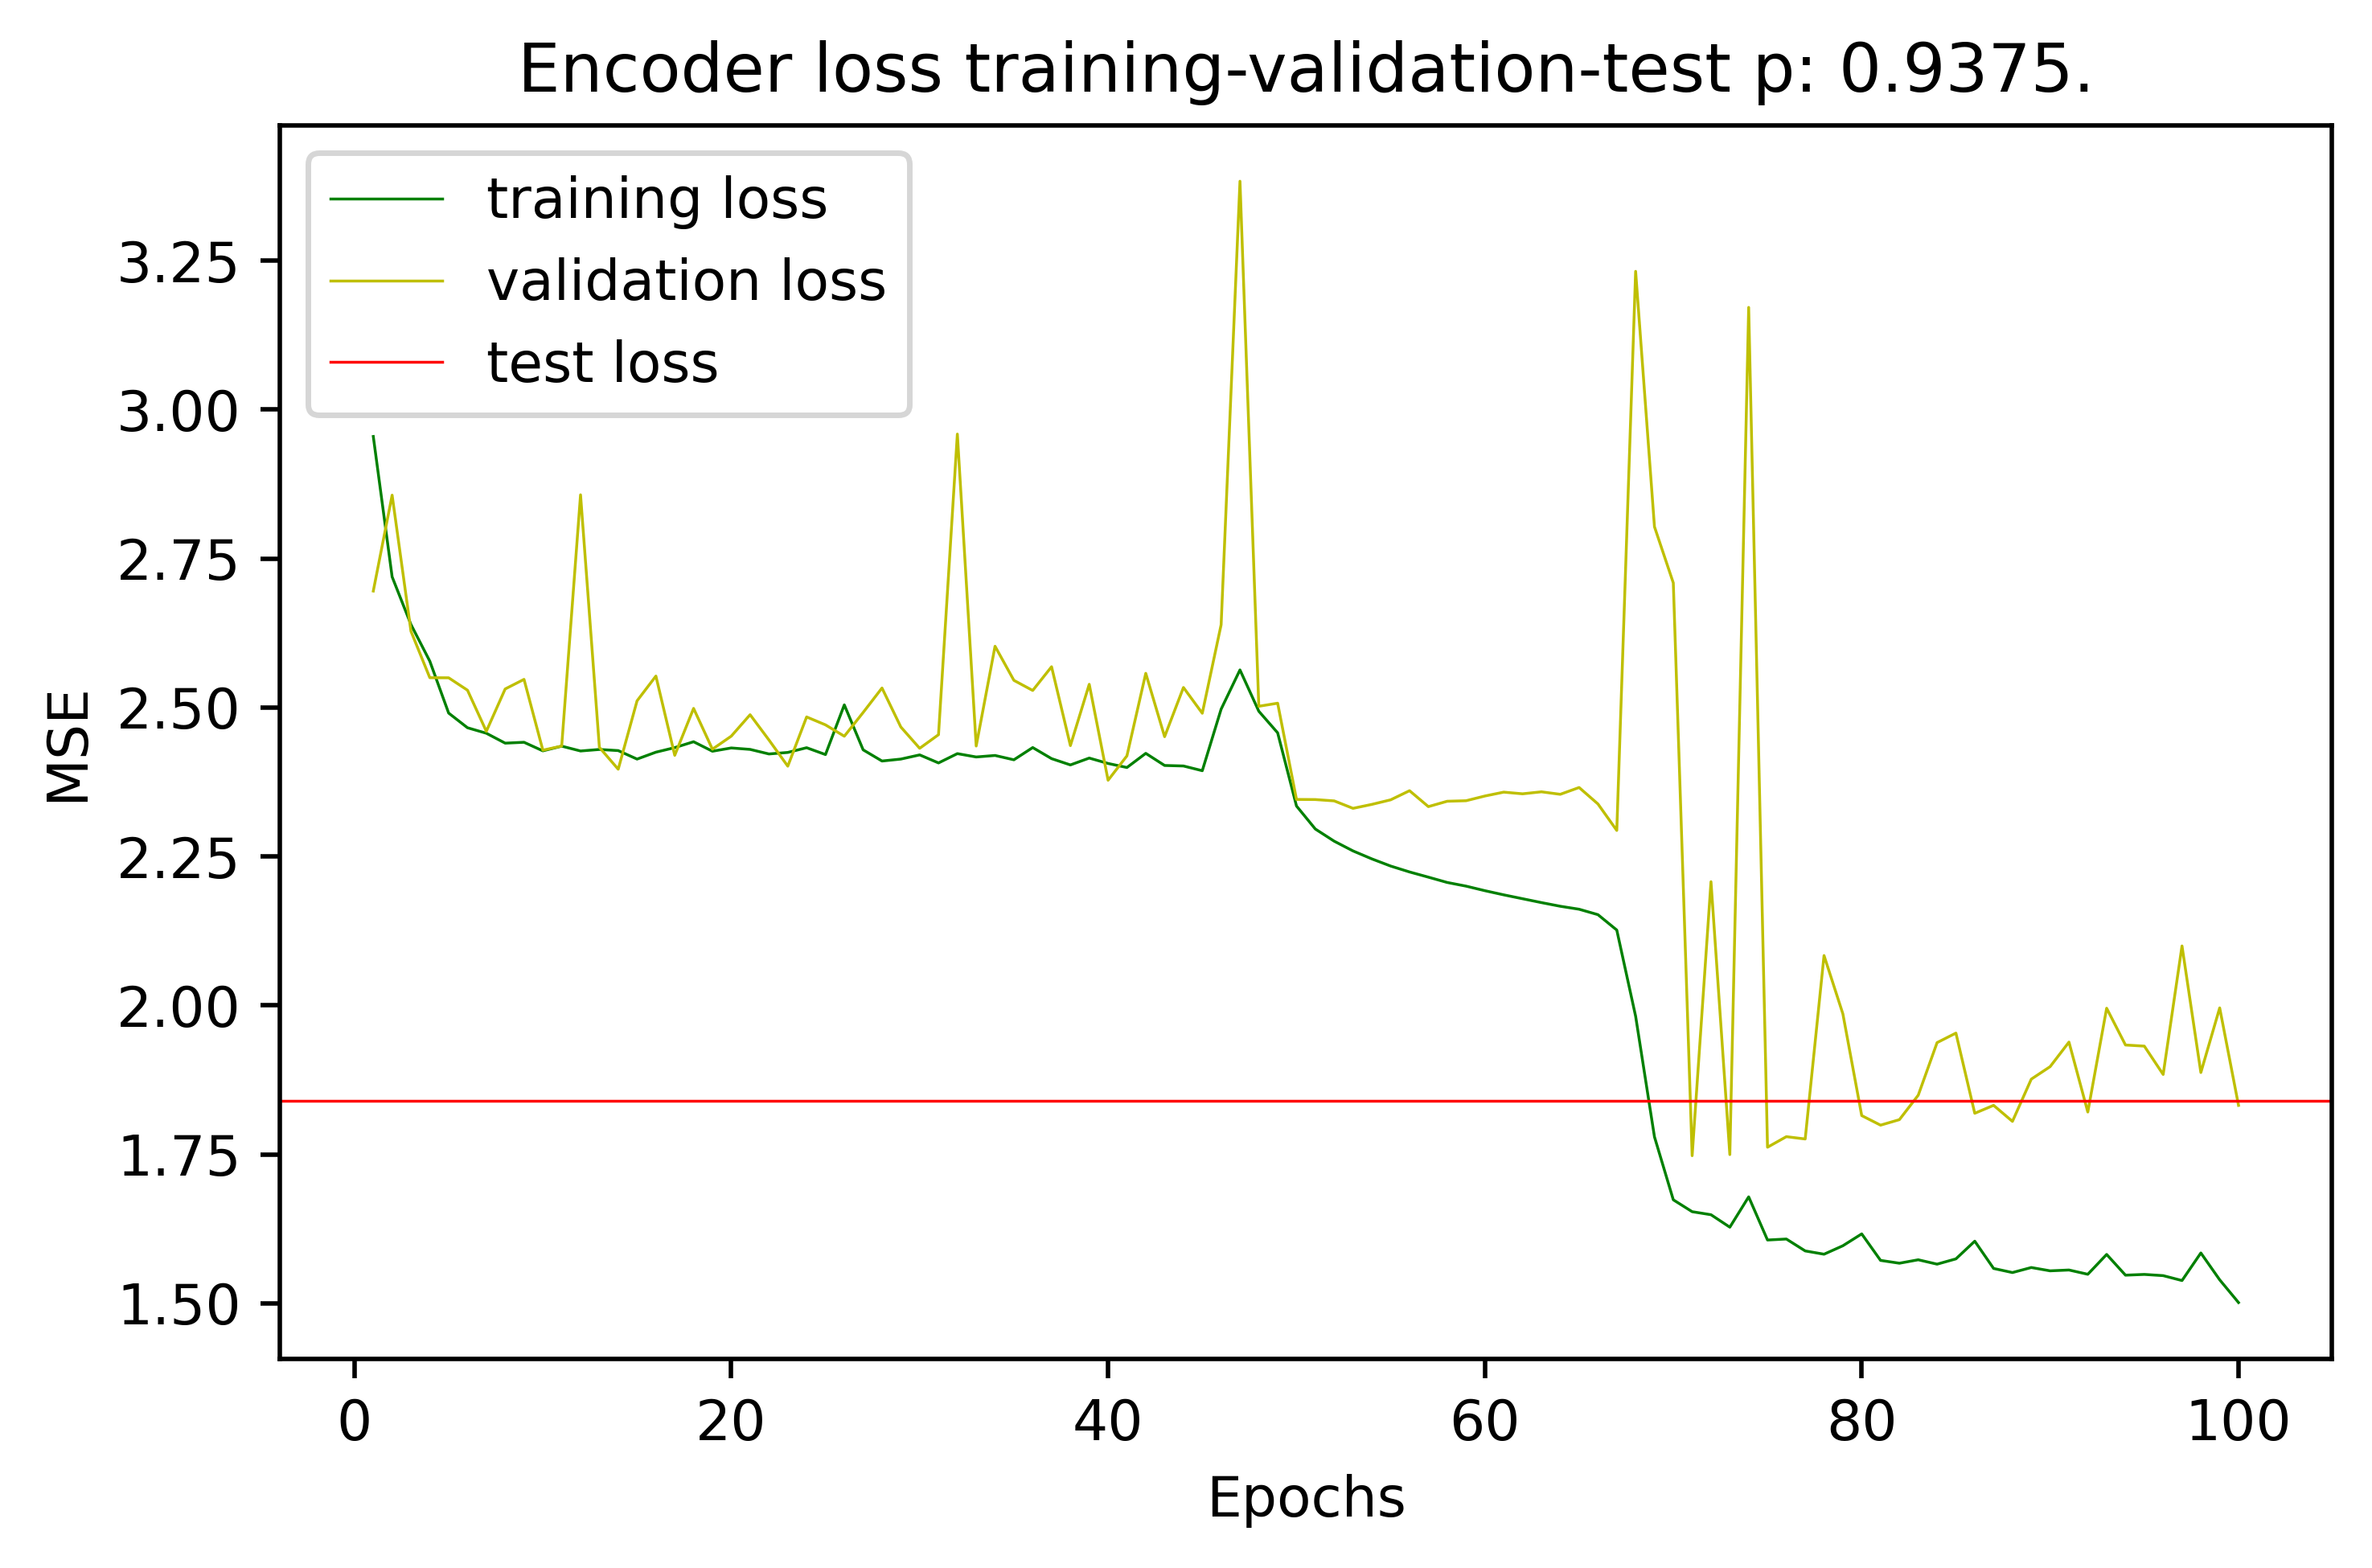

In [12]:

seed_everything(44)

#probs = [1/32]
probs = [1.0, 1-1/32, 1-1/16, 1-1/8, 1-1/4, 1/2, 1/4, 1/8,  1/16, 1/32]
probs.reverse()
noise_type = "salt&pepper"
probs = [1-1/16]
EPOCHS = 100
ROOT_PATH = "/content/drive/MyDrive/"
PATH_MODEL = "Simulations_results/Pendulum/Encoder_big_net_optimal_hyp_big/salt&pepper/models/"
PATH_LOSS = "Simulations_results/Pendulum/Encoder_big_net_optimal_hyp_big/salt&pepper/losses/"
os.makedirs(PATH_MODEL, exist_ok=True)
os.makedirs(PATH_LOSS, exist_ok=True)
plt.figure(dpi=500)
linewidth=0.5
markersize=2
title_size=7
ax_label_size=7
num_work = 4
#configuration = {"learning_rate": 0.000036, "batch_size":512}
#config = {"learning_rate": 0.0036, "weight_decay": 7e-05}


for p in probs:
  with open(f"/content/drive/MyDrive/KalmanNet_Visual/KalmanNet_VO/Simulations_results/Pendulum/Encoder_big_net_optimal_hyp_big/optimal_hyperparameters_p_{p}.txt") as f:
     hyperparameters = json.load(f)
    
  config = {"learning_rate": hyperparameters["learning_rate"], "weight_decay": hyperparameters["weight_decay"]}
  #config = {"learning_rate": 1e-3 , "weight_decay": 1e-8}


  input_path = f"Datasets/Pendulum/Encoder_dataset/pendulum_images_noisy_encoder_big_p_{p}.npz"
 
  PATH_SAVE_MODEL = PATH_MODEL + f"encoder_p_{p}.pt"
  PATH_SAVE_LOSS = PATH_LOSS + f"loss_p_{p}.npz"

  best_model_state, training_loss, validation_loss, validation_loss_deg = train_single(config=config, dir_input=input_path, p=p, noise_type=noise_type)
  model_trained = Encoder(encoded_dimension=1)
  model_trained.load_state_dict(best_model_state)
  mse_loss_linear, mse_loss_dbm, mse_loss_std_db = test_single(dir_input=input_path, p=p, noise_type=noise_type, model=model_trained, criterion=nn.MSELoss())
  print(f"mse_loss_linear: {mse_loss_linear}, log {10*np.log10(mse_loss_linear)}")
  plt.plot(*zip(*training_loss), 'g-', label="training loss", linewidth=linewidth, markersize=markersize)
  plt.plot(*zip(*validation_loss), 'y-', label="validation loss", linewidth=linewidth, markersize=markersize)
  plt.axhline(mse_loss_linear, color='r', label="test loss", linewidth=linewidth)
  plt.title(f"Encoder loss training-validation-test p: {p}.")
  plt.xlabel("Epochs")
  plt.ylabel("MSE")
  plt.legend()
  plt.tight_layout()
  plt.savefig(PATH_LOSS+f"loss_encoder_plot_p_{p}.png", dpi=500)

  plt.show()


[1, 0.96875, 0.9375, 0.875, 0.75, 0.5, 0.25, 0.125, 0.0625, 0.03125]